## Process CDC BRFSS files

Source Files: https://www.cdc.gov/brfss/annual_data/annual_data.htm

### Codebooks
- https://www.cdc.gov/brfss/annual_data/2010/pdf/codebook_10.pdf
- https://www.cdc.gov/brfss/annual_data/2011/pdf/CODEBOOK11_LLCP.pdf
- https://www.cdc.gov/brfss/annual_data/2014/pdf/CODEBOOK14_LLCP.pdf
- https://www.cdc.gov/brfss/annual_data/2015/pdf/CODEBOOK15_LLCP.pdf
- https://www.cdc.gov/brfss/annual_data/2021/pdf/codebook21_llcp-v2-508.pdf
- https://www.cdc.gov/brfss/annual_data/2022/zip/codebook22_llcp-v2-508.zip

#### Import packages and Define source and result file locations

In [1]:
# package imports go here
import pandas as pd
import numpy as np
import fastparquet as fp
import os
import sys
import importlib

sys.path.insert(1, 'pkgs')

# import ml_functions - this contains data cleaning functions defined for this project.
import ml_functions as mlfuncs

# import ml_clean_feature as mlclean
import ml_clean_config as mlconfigs
import ml_clean_feature as mlclean

In [2]:
year = 2021
# Path to source
source_path     = "data/brfss/"
source_file     = mlfuncs.brfss_parquet_file( source_path, year )

# Path to results
result_path     = "data/"
clean_file      = result_path + 'brfss_' + str(year) + '_clean.parquet.gzip'

In [3]:
# Get 2021 data file from CDC and process and save to a parquet file:
year = 2021

# COMMENT OUT SO THIS STEP IS NOT REPEATED
# mlfuncs.process_cdc_file( result_path, year )

In [4]:
df = pd.read_parquet(mlfuncs.brfss_parquet_file( source_path, year ), engine="fastparquet")

In [5]:
df.columns

Index(['_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE',
       'SEQNO', '_PSU', 'CTELENM1',
       ...
       '_FRTRES1', '_VEGRES1', '_FRUTSU1', '_VEGESU1', '_FRTLT1A', '_VEGLT1A',
       '_FRT16A', '_VEG23A', '_FRUITE1', '_VEGETE1'],
      dtype='object', length=303)

## Analyze the set of all candidate features
---
- Reduce full set of features to just the candidate features
- Check for features that have too many null values (>70K)
- Remove features that have too many null values
- Move on to cleaning of each feature

In [6]:
# Full candidate  dataset
diabetes_features_2021_all_candidates = [
    'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'PRIMINSR', 'PERSDOC3', 
    'CHECKUP1', 'EXERANY2', 'BPHIGH6', 'BPMEDS', 'CHOLCHK3', 
    'TOLDHI3', 'CHOLMED3', 'CVDCRHD4', 'CVDSTRK3', 'ADDEPEV3', 
    'CHCKDNY2', 'DIABETE4', 'MARITAL', 'EDUCA', 'RENTHOM1', 
    'EMPLOY1', 'INCOME3', 'WEIGHT2', 'DEAF', 'BLIND', 
    'DIFFWALK', 'FLUSHOT7', 'PREDIAB1', 'CHKHEMO3', 'EYEEXAM1', 
    'TOLDCFS', 'HAVECFS', 'TOLDHEPC', 'HAVEHEPB', 'HPVADVC4', 
    'SHINGLE2', 'CIMEMLOS', 'CDDISCUS', 'MSCODE', '_IMPRACE', 
    '_RFHLTH', '_HLTHPLN', '_TOTINDA', '_MICHD', '_PRACE1', 
    '_RACE', '_RACEGR3', '_SEX', '_AGEG5YR', 'WTKG3', 
    '_BMI5', '_BMI5CAT', '_EDUCAG', '_INCOMG1', '_SMOKER3', 
    '_RFSMOK3', '_CURECI1', '_DRNKWK1', '_RFDRHV7', 'FTJUDA2_', 
    'FRUTDA2_', 'GRENDA1_', 'FRNCHDA_', 'POTADA1_', 'VEGEDA2_', 
    '_FRUTSU1', '_VEGESU1', '_FRTLT1A']

In [7]:
# Create feature dataframe with only candidate diabetes features
feature_df = df[diabetes_features_2021_all_candidates].copy()

In [8]:
# Describe the data
print(feature_df.columns)
print(len(feature_df.columns))

Index(['GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'PRIMINSR', 'PERSDOC3', 'CHECKUP1',
       'EXERANY2', 'BPHIGH6', 'BPMEDS', 'CHOLCHK3', 'TOLDHI3', 'CHOLMED3',
       'CVDCRHD4', 'CVDSTRK3', 'ADDEPEV3', 'CHCKDNY2', 'DIABETE4', 'MARITAL',
       'EDUCA', 'RENTHOM1', 'EMPLOY1', 'INCOME3', 'WEIGHT2', 'DEAF', 'BLIND',
       'DIFFWALK', 'FLUSHOT7', 'PREDIAB1', 'CHKHEMO3', 'EYEEXAM1', 'TOLDCFS',
       'HAVECFS', 'TOLDHEPC', 'HAVEHEPB', 'HPVADVC4', 'SHINGLE2', 'CIMEMLOS',
       'CDDISCUS', 'MSCODE', '_IMPRACE', '_RFHLTH', '_HLTHPLN', '_TOTINDA',
       '_MICHD', '_PRACE1', '_RACE', '_RACEGR3', '_SEX', '_AGEG5YR', 'WTKG3',
       '_BMI5', '_BMI5CAT', '_EDUCAG', '_INCOMG1', '_SMOKER3', '_RFSMOK3',
       '_CURECI1', '_DRNKWK1', '_RFDRHV7', 'FTJUDA2_', 'FRUTDA2_', 'GRENDA1_',
       'FRNCHDA_', 'POTADA1_', 'VEGEDA2_', '_FRUTSU1', '_VEGESU1', '_FRTLT1A'],
      dtype='object')
68


#### Determine columns with >70K null values

---

In [9]:
# Determine features with too many null values (>70K)
cnt = 0
max_allowed_nulls = 70000
maxed_nulls = []
print(f"Features and number of null values")
print(f"----------------------------------")
for column in feature_df.columns:
    cnt += 1
    tot = feature_df[column].isna().sum()
    print(f"Feature[{cnt}]: {column}: {tot}")
    if tot > max_allowed_nulls:
        maxed_nulls.append(f'{column}')

print (f"\nfeatures that exceeded max nulls: \n{maxed_nulls}")

Features and number of null values
----------------------------------
Feature[1]: GENHLTH: 4
Feature[2]: PHYSHLTH: 3
Feature[3]: MENTHLTH: 2
Feature[4]: PRIMINSR: 3
Feature[5]: PERSDOC3: 2
Feature[6]: CHECKUP1: 2
Feature[7]: EXERANY2: 2
Feature[8]: BPHIGH6: 2
Feature[9]: BPMEDS: 266560
Feature[10]: CHOLCHK3: 2
Feature[11]: TOLDHI3: 60836
Feature[12]: CHOLMED3: 61571
Feature[13]: CVDCRHD4: 2
Feature[14]: CVDSTRK3: 2
Feature[15]: ADDEPEV3: 3
Feature[16]: CHCKDNY2: 3
Feature[17]: DIABETE4: 3
Feature[18]: MARITAL: 5
Feature[19]: EDUCA: 5
Feature[20]: RENTHOM1: 8
Feature[21]: EMPLOY1: 3588
Feature[22]: INCOME3: 8847
Feature[23]: WEIGHT2: 11816
Feature[24]: DEAF: 14602
Feature[25]: BLIND: 15744
Feature[26]: DIFFWALK: 18009
Feature[27]: FLUSHOT7: 27648
Feature[28]: PREDIAB1: 324076
Feature[29]: CHKHEMO3: 416464
Feature[30]: EYEEXAM1: 416468
Feature[31]: TOLDCFS: 438693
Feature[32]: HAVECFS: 438693
Feature[33]: TOLDHEPC: 427889
Feature[34]: HAVEHEPB: 427914
Feature[35]: HPVADVC4: 425379
Featur

In [10]:
# Drop featurs with too many null values
feature_df.drop(maxed_nulls, axis=1, inplace=True)
#feature_df.info()

#### Check for correlation with the target feature (DIABETES4)

---

In [11]:
num_top = 10
target = 'DIABETE4'
feature_df.describe()

print(f"Diabetes value counts: feature_df['DIABETE4'].value_counts")

correlations = feature_df.corrwith(feature_df[target])

desc_sorted_correlations = correlations.sort_values(ascending=False)
asc_sorted_correlations = correlations.sort_values()
# Exclude the target itself if present
desc_top_correlations = desc_sorted_correlations.head(num_top + 1).drop(labels=[target], errors='ignore')
asc_top_correlations = asc_sorted_correlations.head(num_top + 1).drop(labels=[target], errors='ignore')

print("\nTop", num_top, "positive correlations:")
print(desc_top_correlations)

print("\nTop", num_top, "negative correlations:")
print(asc_top_correlations)

Diabetes value counts: feature_df['DIABETE4'].value_counts

Top 10 positive correlations:
BPHIGH6     0.240132
CHOLMED3    0.209811
_MICHD      0.158888
DIFFWALK    0.157628
CHCKDNY2    0.149164
CVDSTRK3    0.138277
TOLDHI3     0.131666
CHECKUP1    0.111753
CHOLCHK3    0.097172
ADDEPEV3    0.094598
dtype: float64

Top 10 negative correlations:
GENHLTH    -0.213605
_BMI5      -0.172047
_AGEG5YR   -0.158811
_BMI5CAT   -0.156284
EMPLOY1    -0.147862
WTKG3      -0.141575
_RFHLTH    -0.122632
EXERANY2   -0.073992
_TOTINDA   -0.069500
MENTHLTH   -0.011528
_IMPRACE   -0.005433
dtype: float64


**Note** Very little correlation between individual features and the target feature

#### Determine Correlation between features and drop features with high correlation
---
- A superset of features was used with duplicative information.  i.e. multiple features for exercise, education, insurance, race, fruit and vegetable intake, BMI and weight, etc.
- Basically, drop duplicate features
- The datadset up to this point was run.  However, 225K rows x 55 columns caused exessive caluculation times.  Therefore an analysis for duplicate features will help reduce the columns.

In [12]:
# Create list of current labels
diabetes_labels = feature_df.columns
diabetes_labels

Index(['GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'PRIMINSR', 'PERSDOC3', 'CHECKUP1',
       'EXERANY2', 'BPHIGH6', 'CHOLCHK3', 'TOLDHI3', 'CHOLMED3', 'CVDCRHD4',
       'CVDSTRK3', 'ADDEPEV3', 'CHCKDNY2', 'DIABETE4', 'MARITAL', 'EDUCA',
       'RENTHOM1', 'EMPLOY1', 'INCOME3', 'WEIGHT2', 'DEAF', 'BLIND',
       'DIFFWALK', 'FLUSHOT7', '_IMPRACE', '_RFHLTH', '_HLTHPLN', '_TOTINDA',
       '_MICHD', '_PRACE1', '_RACE', '_RACEGR3', '_SEX', '_AGEG5YR', 'WTKG3',
       '_BMI5', '_BMI5CAT', '_EDUCAG', '_INCOMG1', '_SMOKER3', '_RFSMOK3',
       '_CURECI1', '_DRNKWK1', '_RFDRHV7', 'FTJUDA2_', 'FRUTDA2_', 'GRENDA1_',
       'FRNCHDA_', 'POTADA1_', 'VEGEDA2_', '_FRUTSU1', '_VEGESU1', '_FRTLT1A'],
      dtype='object')

/tmp/ipykernel_330058/2362184927.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', 30)
/tmp/ipykernel_330058/2362184927.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels,fontsize=6)
/tmp/ipykernel_330058/2362184927.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(labels,fontsize=6)


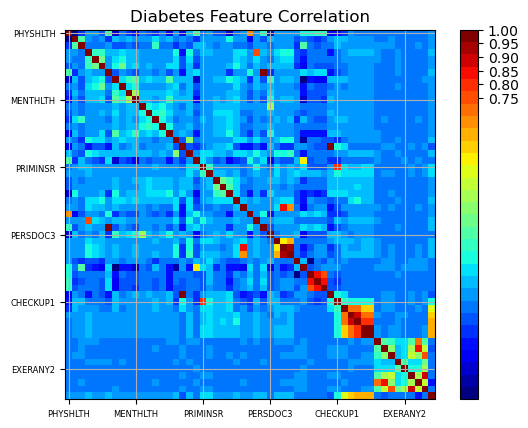

In [13]:
# Create and plot a correlation matrix of all features
def correlation_matrix(df, labels):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Diabetes Feature Correlation')
#    labels=['Sex','Length','Diam','Height','Whole','Shucked','Viscera','Shell','Rings',]
    ax1.set_xticklabels(labels,fontsize=6)
    ax1.set_yticklabels(labels,fontsize=6)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[.75,.8,.85,.90,.95,1])
    plt.show()

correlation_matrix(feature_df, diabetes_labels)

---

**Note:** It appears that we have several features that are similar:  Correlated with each other

#### Caclulate tabular correlation between features

In [14]:
#correlation_df = df.corr()
# Assuming df is your dataframe
correlation_matrix = feature_df.corr()

In [15]:
# Unstack the correlation matrix
correlation_series = correlation_matrix.unstack()

# Convert to DataFrame for better readability
correlation_df = pd.DataFrame(correlation_series, columns=['Correlation'])

# Remove self-correlations by filtering out where the same feature is correlated with itself
correlation_df = correlation_df[correlation_df.index.get_level_values(0) != correlation_df.index.get_level_values(1)]

# Sort by the absolute value of the correlation
correlation_df['AbsoluteCorrelation'] = correlation_df['Correlation'].abs()
sorted_correlation_df = correlation_df.sort_values(by='AbsoluteCorrelation', ascending=False)

# Optionally, you can keep only the top N correlations
sorted_correlation_df.head(60)

,,Correlation,AbsoluteCorrelation
_RFDRHV7,_DRNKWK1,0.996025,0.996025
_DRNKWK1,_RFDRHV7,0.996025,0.996025
EXERANY2,_TOTINDA,0.992476,0.992476
_TOTINDA,EXERANY2,0.992476,0.992476
_EDUCAG,EDUCA,0.979121,0.979121
EDUCA,_EDUCAG,0.979121,0.979121
_RACE,_RACEGR3,0.951210,0.951210
_RACEGR3,_RACE,0.951210,0.951210
_VEGESU1,VEGEDA2_,0.873527,0.873527
VEGEDA2_,_VEGESU1,0.873527,0.873527


**NOTE** High correlation between features.

---

#### Manually Tabulate Duplicate Features (limited automation available)
---
- use following list of features and labels from step 3 in deata_cleaning folder.

In [16]:
# From 3_bfrss_features_1_create_feature_report
    # {'GENHLTH': 'General Health',
    # 'PHYSHLTH': 'Number of Days Physical Health Not Good',
    # 'MENTHLTH': 'Number of Days Mental Health Not Good',
    # 'PRIMINSR': 'What is Primary Source of Health Insurance?',
    # 'PERSDOC3': 'Have Personal Health Care Provider?',
    # 'CHECKUP1': 'Length of time since last routine checkup',
    # 'EXERANY2': 'Exercise in Past 30 Days',
    # 'BPHIGH6': 'Ever Told Blood Pressure High',
    # 'CHOLCHK3': 'How Long since Cholesterol Checked',
    # 'TOLDHI3': 'Ever Told Cholesterol Is High',
    # 'CHOLMED3': 'Currently taking medicine for high cholesterol',
    # 'CVDCRHD4': 'Ever Diagnosed with Angina or Coronary Heart Disease',
    # 'CVDSTRK3': 'Ever Diagnosed with a Stroke',
    # 'ADDEPEV3': '(Ever told) you had a depressive disorder',
    # 'CHCKDNY2': 'Ever told you have kidney disease?',
    # 'DIABETE4': '(Ever told) you had diabetes',
    # 'MARITAL': 'Marital Status',
    # 'EDUCA': 'Education Level',
    # 'RENTHOM1': 'Own or Rent Home',
    # 'EMPLOY1': 'Employment Status',
    # 'INCOME3': 'Income Level',
    # 'WEIGHT2': 'Reported Weight in Pounds',
    # 'DEAF': 'Are you deaf or do you have serious difficulty hearing?',
    # 'BLIND': 'Blind or Difficulty seeing',
    # 'DIFFWALK': 'Difficulty Walking or Climbing Stairs',
    # 'FLUSHOT7': 'Adult flu shot/spray past 12 mos',
    # '_IMPRACE': 'Imputed race/ethnicity value',
    # '_RFHLTH': 'Adults with good or better health',
    # '_HLTHPLN': 'Have any health insurance',
    # '_TOTINDA': 'Leisure Time Physical Activity Calculated Variable',
    # '_MICHD': 'Ever had CHD or MI\u200c',
    # '_PRACE1': 'Computed Preferred Race',
    # '_RACE': 'Computed Race-Ethnicity grouping',
    # '_RACEGR3': 'Computed Five level race/ethnicity category.',
    # '_SEX': 'Calculated sex variable',
    # '_AGEG5YR': 'Reported age in five-year age categories calculated variable',
    # 'WTKG3': 'Computed Weight in Kilograms',
    # '_BMI5': 'Computed body mass index',
    # '_BMI5CAT': 'Computed body mass index categories',
    # '_EDUCAG': 'Computed level of education completed categories',
    # '_INCOMG1': 'Computed income categories',
    # '_SMOKER3': 'Computed Smoking Status',
    # '_RFSMOK3': 'Current Smoking Calculated Variable',
    # '_CURECI1': 'Current E-cigarette User Calculated Variable',
    # '_DRNKWK1': 'Computed number of drinks of alcohol beverages per week',
    # '_RFDRHV7': 'Heavy Alcohol Consumption Calculated Variable',
    # 'FTJUDA2_': 'Computed Fruit Juice intake in times per day',
    # 'FRUTDA2_': 'Computed Fruit intake in times per day',
    # 'GRENDA1_': 'Computed Dark Green Vege',
    # 'FRNCHDA_': 'Computed French Fry intake in times per day',
    # 'POTADA1_': 'Computed Potato Servings per day',
    # 'VEGEDA2_': 'Computed Other Vege',
    # '_FRUTSU1': 'Total fruits consumed per day',
    # '_VEGESU1': 'Total vege',
    # '_FRTLT1A': 'Consume Fruit 1 or more times per day'}


In [17]:
# Defined in 3_brfss_1_create_feature_report.ipynb (copied from there)
# Cutoff at .60.  This is where duplications end and cross correlations begin.
# feature_dict = {'GENHLTH': 'general_health',            # Keep .72 _RFHLTH
#                 'PHYSHLTH': 'days_health_not_good',
#                 'MENTHLTH': 'days_mental_not_good',
#                 'PRIMINSR': 'primary_insurance_source', # Duplicate with _HLTHPLN
#                 'PERSDOC3': 'personal_provider',
#                 'CHECKUP1': 'years_since_checkup',
#                 'EXERANY2': 'exercise',                 # Duplicate with _TOTINDA
#                 'BPHIGH6': 'told_high_blood_pressure',
#                 'CHOLCHK3': 'year_chol_chckd',          # Keep .60 Dup TOLDHI3, CHOLMEDS
#                 'TOLDHI3': 'high_cholesteral',          # Dup .60 CHOLCHK3, CHOLMEDS
#                 'CHOLMED3': 'high_cholesteral_meds',    # Dup .60 CHOLCHK2, CHOLMEDS
#                 'CVDCRHD4': 'ever_heart_disease',       # Dup .81 with _MICHD
#                 'CVDSTRK3': 'ever_stroke',
#                 'ADDEPEV3': 'depressive_disorder',
#                 'CHCKDNY2': 'ekidney_disease',
#                 'DIABETE4': 'diabetes',
#                 'MARITAL': 'marital',
#                 'EDUCA': 'education_level',             # Keep .99 DUp with _EDUCAG 
#                 'RENTHOM1': 'own_home',
#                 'EMPLOY1': 'employment',
#                 'INCOME3': 'income_level',              # Keep .99 Dup with _INCOMG1
#                 'WEIGHT2': 'weight-lbs',
#                 'DEAF': 'hearing',
#                 'BLIND': 'sight',
#                 'DIFFWALK': 'diffwalk',
#                 'FLUSHOT7': 'flu_shot',
#                 '_IMPRACE': 'race_grp5',                # Dup: .96/.95 with _PRACE1, _RACEGR3, _RACE
#                 '_RFHLTH': 'good_health',               # Dup  .72 GENHLTH
#                 '_HLTHPLN': 'have_insurance',           # Keep .99 Dup with PRIMINSR
#                 '_TOTINDA': 'activity_level',           # Keep 1.0 Duplicate with EXERANY2
#                 '_MICHD': 'heart_chd_mi',               # Keep .81 Dup with CVDCRHD4
#                 '_PRACE1': 'race_grp8',                 # Dup: .96/.95 with _IMRACE, _RACEGR3, _RACE
#                 '_RACE': 'race_grp8a',                  # Keep .96/.95 with _IMPRACE, _PRACE1, _RACEGR3
#                 '_RACEGR3': 'race_grp5a',               # Dup: .96/.95 with _IMPRACE, _PRACE1, _RACE
#                 '_SEX': 'sex',
#                 '_AGEG5YR': 'age_5yr',
#                 'WTKG3': 'weight_kilos',                # Dup .86 with _BMI
#                 '_BMI5': 'body_mass_index',             # Dup .85 with _BMICAT
#                 '_BMI5CAT': 'BMI_cats',                 # Keep .85 with _BMI5 (2015)
#                 '_EDUCAG': 'ceduc_cats',                # Duplicate with EDUCA
#                 '_INCOMG1': 'income _cats',             # Dup .99 with INCOME3
#                 '_SMOKER3': 'smoking_status',           # Keep Dup .72 _RFSMOK3
#                 '_RFSMOK3': 'smoking_yn',               # Dup .72 _SMOKER3
#                 '_CURECI1': 'ecig_yn',
#                 '_DRNKWK1': 'drinks_week',              # Dup .62 with _RFDRHV7
#                 '_RFDRHV7': 'drinks_cats',              # Keep .62 Dup with _DRNKWK1
#                 'FTJUDA2_': 'fruit_juice',              # Dup with .71 _FRUTSU1
#                 'FRUTDA2_': 'fruit_times_perday',       # Dup with .86 _FRUTSU1
#                 'GRENDA1_': 'darkG_vege',               # Dup with .76 _VEGESU1
#                 'FRNCHDA_': 'french_fry',
#                 'POTADA1_': 'potato',
#                 'VEGEDA2_': 'other_vege',               # Dup with .87 _VEGESU1
#                 '_FRUTSU1': 'tot_fruits',               # Keep Dup with .86 FRUTDA2_, .71 FTJUDA2_
#                 '_VEGESU1': 'tot_vege',                 # Keep: Dup with .76 GRENDA1_, .87 VEGEDA2_
#                 '_FRTLT1A': 'fruit_1_yn'}

#### Below is the list of variables to keep after removing the duplicates defined above.

---

In [18]:
features_to_keep_list = ['GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'PERSDOC3', 'CHECKUP1',
       'BPHIGH6', 'CHOLCHK3',
       'CVDSTRK3', 'ADDEPEV3', 'CHCKDNY2', 'DIABETE4', 'MARITAL', 'EDUCA',
       'RENTHOM1', 'EMPLOY1', 'INCOME3', 'WEIGHT2', 'DEAF', 'BLIND',
       'DIFFWALK', 'FLUSHOT7', '_HLTHPLN', '_TOTINDA',
       '_MICHD', '_RACE', '_SEX', '_AGEG5YR',
       '_BMI5CAT', '_SMOKER3', '_RFSMOK3',
       '_CURECI1', '_RFDRHV7',
       'FRNCHDA_', 'POTADA1_', '_FRUTSU1', '_VEGESU1', '_FRTLT1A']

In [19]:
# Create a new df with just the features_to_keep_list columns
feature2_df = feature_df[features_to_keep_list].copy()

In [20]:
feature2_df

,GENHLTH,PHYSHLTH,MENTHLTH,PERSDOC3,CHECKUP1,BPHIGH6,CHOLCHK3,CVDSTRK3,ADDEPEV3,CHCKDNY2,...,_BMI5CAT,_SMOKER3,_RFSMOK3,_CURECI1,_RFDRHV7,FRNCHDA_,POTADA1_,_FRUTSU1,_VEGESU1,_FRTLT1A
0,5.0,20.0,10.0,1.0,2.0,3.0,2.0,2.0,2.0,2.0,...,1.0,3.0,1.0,1.0,1.0,4.300000e+01,14.0,100.0,214.0,1.0
1,3.0,88.0,88.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,...,NaN,4.0,1.0,1.0,1.0,5.397605e-79,14.0,100.0,128.0,1.0
2,2.0,88.0,88.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,...,3.0,4.0,1.0,1.0,1.0,1.400000e+01,14.0,100.0,71.0,1.0
3,2.0,88.0,10.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,...,4.0,4.0,1.0,1.0,1.0,5.700000e+01,27.0,114.0,165.0,1.0
4,5.0,30.0,88.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,...,3.0,4.0,1.0,1.0,1.0,2.900000e+01,29.0,100.0,258.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438688,2.0,88.0,20.0,3.0,4.0,1.0,6.0,2.0,1.0,2.0,...,2.0,3.0,1.0,1.0,1.0,1.400000e+01,50.0,157.0,393.0,1.0
438689,3.0,88.0,88.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,...,NaN,4.0,1.0,1.0,1.0,1.400000e+01,14.0,200.0,157.0,1.0
438690,2.0,88.0,88.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0,...,4.0,4.0,1.0,1.0,1.0,5.397605e-79,14.0,200.0,143.0,1.0
438691,2.0,88.0,88.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,...,2.0,4.0,1.0,1.0,1.0,5.397605e-79,13.0,100.0,156.0,1.0


Recalculate the Correlation Matrix.

---

In [21]:
#correlation_df = df.corr()
# Assuming df is your dataframe
correlation_matrix = feature2_df.corr()

In [22]:
# Unstack the correlation matrix
correlation_series = correlation_matrix.unstack()

# Convert to DataFrame for better readability
correlation_df = pd.DataFrame(correlation_series, columns=['Correlation'])

# Remove self-correlations by filtering out where the same feature is correlated with itself
correlation_df = correlation_df[correlation_df.index.get_level_values(0) != correlation_df.index.get_level_values(1)]

# Sort by the absolute value of the correlation
correlation_df['AbsoluteCorrelation'] = correlation_df['Correlation'].abs()
sorted_correlation_df = correlation_df.sort_values(by='AbsoluteCorrelation', ascending=False)

# Optionally, you can keep only the top N correlations
sorted_correlation_df.head(20)

Correlation  AbsoluteCorrelation
_RFSMOK3 _CURECI1     0.873298             0.873298
_CURECI1 _RFSMOK3     0.873298             0.873298
         _RFDRHV7     0.789232             0.789232
_RFDRHV7 _CURECI1     0.789232             0.789232
_RFSMOK3 _RFDRHV7     0.725943             0.725943
_RFDRHV7 _RFSMOK3     0.725943             0.725943
_RFSMOK3 _SMOKER3     0.720996             0.720996
_SMOKER3 _RFSMOK3     0.720996             0.720996
         _CURECI1     0.716501             0.716501
_CURECI1 _SMOKER3     0.716501             0.716501
_FRTLT1A _CURECI1     0.631257             0.631257
_CURECI1 _FRTLT1A     0.631257             0.631257
_FRTLT1A _RFDRHV7     0.607160             0.607160
_RFDRHV7 _FRTLT1A     0.607160             0.607160
         _SMOKER3     0.584320             0.584320
_SMOKER3 _RFDRHV7     0.584320             0.584320
_RFSMOK3 _FRTLT1A     0.579791             0.579791
_FRTLT1A _RFSMOK3     0.579791             0.579791
EMPLOY1  _AGEG5YR     0.511347             0.511347
_AGEG5YR EMPLOY1      0.511347             0.511347

**NOTES** Final Correlations are not useful.  i.e. alcohol and smoking
- No more Duplicates are considered for removal at this time
---

#### Re-check number of nulls per column

In [23]:
# Determine features with too many null values (>70K)
cnt = 0
max_allowed_nulls = 70000
maxed_nulls = []
print(f"Features and number of null values")
print(f"----------------------------------")
for column in feature2_df.columns:
    cnt += 1
    tot = feature2_df[column].isna().sum()
    print(f"Feature[{cnt}]: {column}: {tot}")
    if tot > max_allowed_nulls:
        maxed_nulls.append(f'{column}')

print (f"\nfeatures that exceeded max nulls: \n{maxed_nulls}")

Features and number of null values
----------------------------------
Feature[1]: GENHLTH: 4
Feature[2]: PHYSHLTH: 3
Feature[3]: MENTHLTH: 2
Feature[4]: PERSDOC3: 2
Feature[5]: CHECKUP1: 2
Feature[6]: BPHIGH6: 2
Feature[7]: CHOLCHK3: 2
Feature[8]: CVDSTRK3: 2
Feature[9]: ADDEPEV3: 3
Feature[10]: CHCKDNY2: 3
Feature[11]: DIABETE4: 3
Feature[12]: MARITAL: 5
Feature[13]: EDUCA: 5
Feature[14]: RENTHOM1: 8
Feature[15]: EMPLOY1: 3588
Feature[16]: INCOME3: 8847
Feature[17]: WEIGHT2: 11816
Feature[18]: DEAF: 14602
Feature[19]: BLIND: 15744
Feature[20]: DIFFWALK: 18009
Feature[21]: FLUSHOT7: 27648
Feature[22]: _HLTHPLN: 0
Feature[23]: _TOTINDA: 0
Feature[24]: _MICHD: 4635
Feature[25]: _RACE: 0
Feature[26]: _SEX: 0
Feature[27]: _AGEG5YR: 0
Feature[28]: _BMI5CAT: 46852
Feature[29]: _SMOKER3: 0
Feature[30]: _RFSMOK3: 0
Feature[31]: _CURECI1: 0
Feature[32]: _RFDRHV7: 0
Feature[33]: FRNCHDA_: 44765
Feature[34]: POTADA1_: 48440
Feature[35]: _FRUTSU1: 51087
Feature[36]: _VEGESU1: 60127
Feature[37]: _F

#### Drop all rows with null values

---

In [24]:
# Drop all rows with null values
feature2_df.dropna(inplace=True)

In [25]:
feature2_df

,GENHLTH,PHYSHLTH,MENTHLTH,PERSDOC3,CHECKUP1,BPHIGH6,CHOLCHK3,CVDSTRK3,ADDEPEV3,CHCKDNY2,...,_BMI5CAT,_SMOKER3,_RFSMOK3,_CURECI1,_RFDRHV7,FRNCHDA_,POTADA1_,_FRUTSU1,_VEGESU1,_FRTLT1A
0,5.0,20.0,10.0,1.0,2.0,3.0,2.0,2.0,2.0,2.0,...,1.0,3.0,1.0,1.0,1.0,4.300000e+01,14.0,100.0,214.0,1.0
2,2.0,88.0,88.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,...,3.0,4.0,1.0,1.0,1.0,1.400000e+01,14.0,100.0,71.0,1.0
3,2.0,88.0,10.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,...,4.0,4.0,1.0,1.0,1.0,5.700000e+01,27.0,114.0,165.0,1.0
4,5.0,30.0,88.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,...,3.0,4.0,1.0,1.0,1.0,2.900000e+01,29.0,100.0,258.0,1.0
5,3.0,88.0,88.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0,...,2.0,3.0,1.0,1.0,1.0,5.397605e-79,14.0,29.0,42.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438687,4.0,88.0,88.0,1.0,3.0,1.0,4.0,2.0,2.0,2.0,...,2.0,4.0,1.0,1.0,1.0,1.400000e+01,14.0,250.0,299.0,1.0
438688,2.0,88.0,20.0,3.0,4.0,1.0,6.0,2.0,1.0,2.0,...,2.0,3.0,1.0,1.0,1.0,1.400000e+01,50.0,157.0,393.0,1.0
438690,2.0,88.0,88.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0,...,4.0,4.0,1.0,1.0,1.0,5.397605e-79,14.0,200.0,143.0,1.0
438691,2.0,88.0,88.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,...,2.0,4.0,1.0,1.0,1.0,5.397605e-79,13.0,100.0,156.0,1.0


In [26]:
feature2_df['DIABETE4'].value_counts()

DIABETE4
3.0    286423
1.0     44720
4.0      7830
2.0      2938
7.0       321
9.0        33
Name: count, dtype: int64

### Modify Column Encodings

---

In [27]:
# Load clean_configs to drive the cleaning operations
clean_configs = mlconfigs.clean_configurations()

In [28]:
# reload any changes to mlconfigs
importlib.reload(mlclean)

# Call a function to clean the files using the configuration dictionary in 
# ml_clean_feature.py

df = mlclean.clean_all_features(feature2_df, clean_configs)



Cleaning Feature: GENHLTH
  Initial Unique features in [GENHLTH]:  [1. 2. 3. 4. 5. 7. 9.]
  values_to_drop: [7, 9]
  translate: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}


  scale: ********* NO Parameters were specified *********
  FINAL Unique features in [GENHLTH]:  [0. 1. 2. 3. 4.]


Cleaning Feature: PHYSHLTH
  Initial Unique features in [PHYSHLTH]:  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 77. 88. 99.]
  values_to_drop: [77, 99]
  translate: {88: 0}
  scale: ********* NO Parameters were specified *********
  FINAL Unique features in [PHYSHLTH]:  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]


Cleaning Feature: MENTHLTH
  Initial Unique features in [MENTHLTH]:  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 77. 88. 99.]
  values_to_drop: [77, 99]
  translate: {88: 0}
  scale: ********* NO Parameters were specified *********
  FINAL Unique features in [MENTHLTH]:  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13

/mnt/c/ML/DU/repos/projects/project-2/DU-project-2/pkgs/ml_clean_feature.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df[column] = feature_df[column].replace(params)


  translate: {3: 0}
  scale: ********* NO Parameters were specified *********
  FINAL Unique features in [PERSDOC3]:  [0. 1. 2.]


Cleaning Feature: CHECKUP1
  Initial Unique features in [CHECKUP1]:  [1. 2. 3. 4. 7. 8. 9.]
  values_to_drop: [7, 9]
  translate: {8: 0}
  scale: ********* NO Parameters were specified *********
  FINAL Unique features in [CHECKUP1]:  [0. 1. 2. 3. 4.]


Cleaning Feature: BPHIGH6
  Initial Unique features in [BPHIGH6]:  [1. 2. 3. 4. 7. 9.]
  values_to_drop: [7, 9]
  translate: {3: 0, 1: 5}
  translate2: {2: 1, 4: 2, 5: 3}
  scale: ********* NO Parameters were specified *********
  FINAL Unique features in [BPHIGH6]:  [0. 1. 2. 3.]


Cleaning Feature: CHOLCHK3
  Initial Unique features in [CHOLCHK3]:  [1. 2. 3. 4. 5. 6. 7. 8. 9.]
  values_to_drop: [7, 9]
  translate: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 8: 6}
  scale: ********* NO Parameters were specified *********
  FINAL Unique features in [CHOLCHK3]:  [0. 1. 2. 3. 4. 5. 6.]


Cleaning Feature: CVDSTRK3
  

In [29]:
# Final clean dataset from parquet file and count of DIABETE4 target column
df['DIABETE4'].value_counts()

DIABETE4
0.0    208389
2.0     33033
1.0      5654
Name: count, dtype: int64

### Rename the columns

---

In [30]:
# Defined in 3_brfss_1_create_feature_report.ipynb (copied from there)
# Cutoff at .60.  This is where duplications end and cross correlations begin.

feature_dict = {'GENHLTH': 'general_health',            # Keep .72 _RFHLTH
                'PHYSHLTH': 'days_health_not_good',
                'MENTHLTH': 'days_mental_not_good',
                'PERSDOC3': 'personal_provider',
                'CHECKUP1': 'years_since_checkup',
                'BPHIGH6': 'told_high_blood_pressure',
                'CHOLCHK3': 'year_chol_chckd',          # Keep .60 Dup TOLDHI3, CHOLMEDS
                'CVDSTRK3': 'ever_stroke',
                'ADDEPEV3': 'depressive_disorder',
                'CHCKDNY2': 'kidney_disease',
                'DIABETE4': 'diabetes',
                'MARITAL': 'marital',
                'EDUCA': 'education_level',             # Keep .99 DUp with _EDUCAG 
                'RENTHOM1': 'own_home',
                'EMPLOY1': 'employment',
                'INCOME3': 'income_level',              # Keep .99 Dup with _INCOMG1
                'WEIGHT2': 'weight-lbs',
                'DEAF': 'hearing',
                'BLIND': 'sight',
                'DIFFWALK': 'diffwalk',
                'FLUSHOT7': 'flu_shot',
                '_HLTHPLN': 'have_insurance',           # Keep .99 Dup with PRIMINSR
                '_TOTINDA': 'activity_level',           # Keep 1.0 Duplicate with EXERANY2
                '_MICHD': 'heart_chd_mi',               # Keep .81 Dup with CVDCRHD4
                '_RACE': 'race_grp8a',                  # Keep .96/.95 with _IMPRACE, _PRACE1, _RACEGR3
                '_SEX': 'sex',
                '_AGEG5YR': 'age_5yr',
                '_BMI5CAT': 'BMI_cats',                 # Keep .85 with _BMI5 (2015)
                '_SMOKER3': 'smoking_status',           # Keep Dup .72 _RFSMOK3
                '_CURECI1': 'ecig_yn',
                '_RFDRHV7': 'drinks_cats',              # Keep .62 Dup with _DRNKWK1
                'FRNCHDA_': 'french_fry',
                'POTADA1_': 'potato',
                '_FRUTSU1': 'tot_fruits',               # Keep Dup with .86 FRUTDA2_, .71 FTJUDA2_
                '_VEGESU1': 'tot_vege',                 # Keep: Dup with .76 GRENDA1_, .87 VEGEDA2_
                '_FRTLT1A': 'fruit_1_yn'}

In [31]:
# Rename the columns
final_feature_df = df.rename(columns=feature_dict)

In [32]:
final_feature_df.columns

Index(['general_health', 'days_health_not_good', 'days_mental_not_good',
       'personal_provider', 'years_since_checkup', 'told_high_blood_pressure',
       'year_chol_chckd', 'ever_stroke', 'depressive_disorder',
       'kidney_disease', 'diabetes', 'marital', 'education_level', 'own_home',
       'employment', 'income_level', 'weight-lbs', 'hearing', 'sight',
       'diffwalk', 'flu_shot', 'have_insurance', 'activity_level',
       'heart_chd_mi', 'race_grp8a', 'sex', 'age_5yr', 'BMI_cats',
       'smoking_status', '_RFSMOK3', 'ecig_yn', 'drinks_cats', 'french_fry',
       'potato', 'tot_fruits', 'tot_vege', 'fruit_1_yn'],
      dtype='object')

In [33]:
final_feature_df

,general_health,days_health_not_good,days_mental_not_good,personal_provider,years_since_checkup,told_high_blood_pressure,year_chol_chckd,ever_stroke,depressive_disorder,kidney_disease,...,BMI_cats,smoking_status,_RFSMOK3,ecig_yn,drinks_cats,french_fry,potato,tot_fruits,tot_vege,fruit_1_yn
0,4.0,20.0,10.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,4.300000e+01,1.400000e+01,100.0,214.0,1.0
2,1.0,0.0,0.0,2.0,1.0,3.0,1.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.400000e+01,1.400000e+01,100.0,71.0,1.0
3,1.0,0.0,10.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,1.0,5.700000e+01,2.700000e+01,114.0,165.0,1.0
4,4.0,30.0,0.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,2.900000e+01,2.900000e+01,100.0,258.0,1.0
5,2.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,5.397605e-79,1.400000e+01,29.0,42.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438685,2.0,0.0,0.0,1.0,3.0,3.0,6.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,5.397605e-79,7.000000e+00,57.0,150.0,2.0
438686,1.0,5.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,5.397605e-79,5.397605e-79,200.0,72.0,1.0
438687,3.0,0.0,0.0,1.0,3.0,3.0,3.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.400000e+01,1.400000e+01,250.0,299.0,1.0
438690,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,1.0,5.397605e-79,1.400000e+01,200.0,143.0,1.0


In [34]:
# Write final cleaned dataset to parquet file
final_feature_df.to_parquet(clean_file, compression='gzip', engine="fastparquet")
# Read final cleaned dataset from parquet file
df = pd.read_parquet(clean_file, engine="fastparquet")

In [35]:
df

,general_health,days_health_not_good,days_mental_not_good,personal_provider,years_since_checkup,told_high_blood_pressure,year_chol_chckd,ever_stroke,depressive_disorder,kidney_disease,...,BMI_cats,smoking_status,_RFSMOK3,ecig_yn,drinks_cats,french_fry,potato,tot_fruits,tot_vege,fruit_1_yn
index,,,,,,,,,,,,,,,,,,,,,
0,4.0,20.0,10.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,4.300000e+01,1.400000e+01,100.0,214.0,1.0
2,1.0,0.0,0.0,2.0,1.0,3.0,1.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.400000e+01,1.400000e+01,100.0,71.0,1.0
3,1.0,0.0,10.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,1.0,5.700000e+01,2.700000e+01,114.0,165.0,1.0
4,4.0,30.0,0.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,2.900000e+01,2.900000e+01,100.0,258.0,1.0
5,2.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,5.397605e-79,1.400000e+01,29.0,42.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438685,2.0,0.0,0.0,1.0,3.0,3.0,6.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,5.397605e-79,7.000000e+00,57.0,150.0,2.0
438686,1.0,5.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,5.397605e-79,5.397605e-79,200.0,72.0,1.0
438687,3.0,0.0,0.0,1.0,3.0,3.0,3.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.400000e+01,1.400000e+01,250.0,299.0,1.0


In [36]:
# Final clean dataset from parquet file and count of DIABETE4 target column
df['diabetes'].value_counts()

diabetes
0.0    208389
2.0     33033
1.0      5654
Name: count, dtype: int64